In [1]:
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.dc import DC
from nanodrivers.visa_drivers.vna import VNA

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize

#file_store
import os

#time
import time
from datetime import datetime, timedelta


from ctypes import *
%matplotlib inline

C:\Users\Demag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,0.4.204



In [2]:
dc = DC()
dc.idn()

Connection exist: HEWLETT-PACKARD,33120A,0,7.0-5.0-1.0



In [12]:
dc.query('FUNCtion:SHAP?')

'DC\n'

In [11]:
dc.write('FUNCtion:SHAP DC')

In [14]:
dc.write('OUTPut:LOAD 50')
dc.get_volt(0)

AttributeError: 'DC' object has no attribute 'get_volt'

In [5]:
vna = VNA()
vna.idn()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



In [ ]:
vna.idn()

# Set all devises to default values

In [122]:
anapico.off(1)
dc.set_volt(0)

def get_ref_gain():
    anapico.off(1)
    dc.set_volt(0)
    time.sleep(5)
    mag, pha = vna.get_data()
    reference_mag_level = np.mean(mag)
    return reference_mag_level

def get_gain(freq_curr, powers_curr, dc_curr, mag_ref):
    anapico.set_freq(1, freq_curr*1e9)
    anapico.set_power(1, powers_curr)
    dc.set_volt(dc_curr)
    anapico.on(1)
    mag, pha = vna.get_data()
    gain = np.mean(mag) - mag_ref
    return gain

In [123]:
mag_ref = get_ref_gain()
print('Reference level with TWPA off:', mag_ref)

Reference level with TWPA off: -54.808086998799894


In [60]:
# boundaries

freq_pump_max = 11.7 #GHz
freq_pump_min = 10.9 #GHz

power_pump_max = -6 #dBm
power_pump_min = -29 #dBm

dc_max = 2.8 # V
dc_min = 1 # V

In [50]:
est_fr = 11.296
est_pow = -21.9
est_dc = 2.3
gain = get_gain(est_fr, est_pow, est_dc, mag_ref)
print('Gain with TWPA on:', gain)

Gain with TWPA on: 1.3820934069349917


# Scan freq and power range

In [1]:
def get_freq_sweep(powers_curr, dc_curr, fr_steps = 10): 
    
    anapico.set_power(1, powers_curr)
    dc.set_volt(dc_curr)
    freq = np.linspace(freq_pump_min, freq_pump_max, fr_steps)
    gain = np.array([])
    anapico.on(1)
    time.sleep(5)
    for i in range(fr_steps):
        anapico.set_freq(1, freq[i]*1e9)
        mag, pha = vna.get_data()
        gain = np.append(gain, np.mean(mag)-mag_ref)
    return freq, gain

def get_power_sweep(freq, dc_curr, pow_steps = 10): 
    
    anapico.set_freq(1, freq*1e9)
    dc.set_volt(dc_curr)
    power = np.linspace(power_pump_min, power_pump_max, pow_steps)
    gain = np.array([])
    anapico.on(1)
    time.sleep(5)
    for i in range(pow_steps):
        anapico.set_power(1, power[i])
        mag, pha = vna.get_data()
        gain = np.append(gain, np.mean(mag)-mag_ref)
    return power, gain

# PF sweep

In [175]:
def get_FP_sweep(dc_curr, freq_steps = 10, pow_steps = 10): 
    dc.set_volt(dc_curr)
    
    power = np.linspace(low_power, high_power, pow_steps)
    freq = np.linspace(low_freq, high_freq, freq_steps)
    anapico.on(1)
#     time.sleep(5)
    
    gain = np.empty(( pow_steps,freq_steps))
    for i in range(pow_steps):
        for j in range(freq_steps):
            anapico.set_power(1, power[i])
            anapico.set_freq(1, freq[j]*1e9)
            mag, pha = vna.get_data()
            gain[i,j] = np.mean(mag)-mag_ref
    
    return power, freq, gain

In [122]:
low_power = -14
high_power = -10
power_mid = (low_power+high_power)/2

In [123]:
low_freq = 11.1
high_freq = 11.5
freq_mid = (low_freq+high_freq)

Duration: 0:00:40.611470


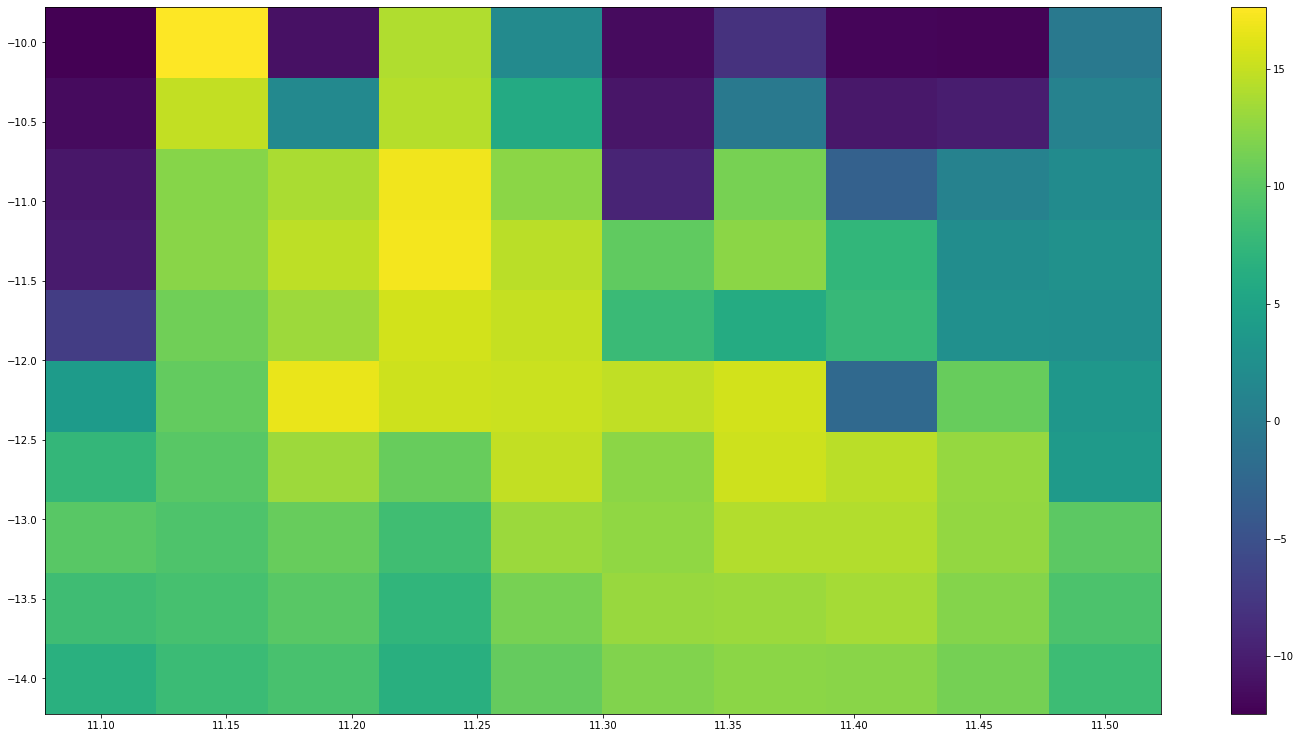

In [124]:
start_time = datetime.now()
fig, ax = plt.subplots(figsize=(25,13))
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 10, pow_steps = 10) 
c = ax.pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:01:51.647533


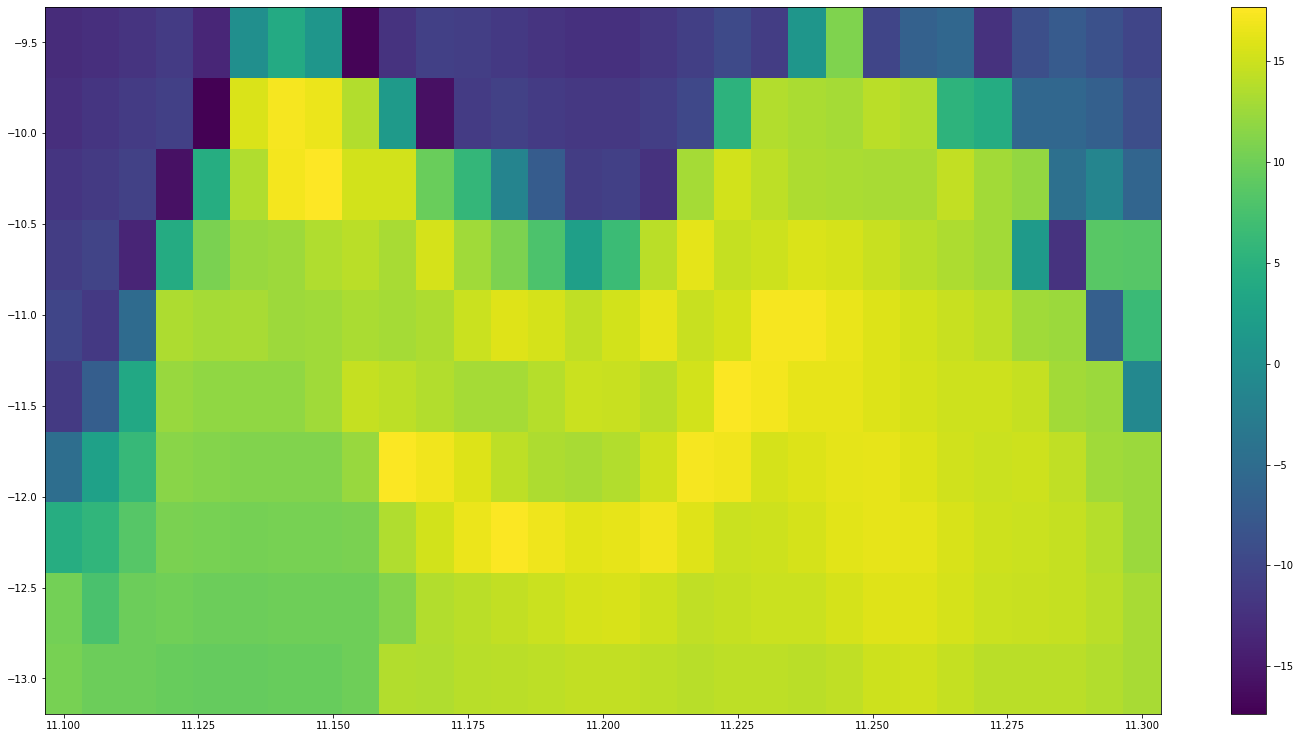

In [129]:
%matplotlib inline
low_freq = 11.1
high_freq = 11.3
low_power = -13
high_power = -9.5

start_time = datetime.now()
fig, ax = plt.subplots(figsize=(25,13))
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 30, pow_steps = 10) 
c = ax.pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [166]:
# find 4 largest candidates

indices = gain.ravel().argsort()
amax = gain.ravel()[indices[-4:]]
p = np.array([])
f = np.array([])
for i in range(4):
    amax_local = amax[i]
    r1, c1 = np.where(gain == amax_local)
    p = np.append(p, power[r1[0]])
    f = np.append(f, freq[c1[0]])
    print('pow[{}]={}, freq[{}]={}: {}'.format(r1[0], power[r1[0]], c1[0], freq[c1[0]], amax_local) )

pow[2]=-12.222222222222221, freq[12]=11.182758620689656: 17.432368961900217
pow[3]=-11.833333333333334, freq[9]=11.162068965517241: 17.44700624953927
pow[4]=-11.444444444444445, freq[18]=11.224137931034482: 17.4921023362091
pow[7]=-10.277777777777779, freq[7]=11.148275862068965: 17.669440867952346


In [168]:
%matplotlib qt

fig, ax = plt.subplots(2, 2,figsize=(25,13))

offset_f = 0.05
offset_p = 0.3

start_time = datetime.now()
low_freq = f[0]-offset_f
high_freq = f[0]+offset_f
low_power = p[0]-offset_p
high_power = p[0]+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 20, pow_steps = 20) 
c = ax[0,0].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax[0,0])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
low_freq = f[1]-offset_f
high_freq = f[1]+offset_f
low_power = p[1]-offset_p
high_power = p[1]+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 20, pow_steps = 20) 
c = ax[0,1].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax[0,1])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
low_freq = f[2]-offset_f
high_freq = f[2]+offset_f
low_power = p[2]-offset_p
high_power = p[2]+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 20, pow_steps = 20) 
c = ax[1,0].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax[1,0])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
low_freq = f[3]-offset_f
high_freq = f[3]+offset_f
low_power = p[3]-offset_p
high_power = p[3]+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 20, pow_steps = 20) 
c = ax[1,1].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax[1,1])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:02:27.182780
Duration: 0:02:27.111038
Duration: 0:02:27.215555
Duration: 0:02:27.349955


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25,13))

cent_freq = 11.182
cent_pow = -11.54

offset_f = 0.01
offset_p = 0.1
start_time = datetime.now()
low_freq = cent_freq-offset_f
high_freq = cent_freq+offset_f
low_power = cent_pow-offset_p
high_power = cent_pow+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.38, freq_steps = 5, pow_steps = 5) 
c = ax[0].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax= ax[0])


cent_freq = cent_freq/2*1e9
span = 45e6
nop = 1001
min_freq = cent_freq-span/2
max_freq = cent_freq+span/2
freq = np.linspace(min_freq, max_freq, nop)
band=100

sa.set_cent_freq(cent_freq)
sa.set_span(span)
sa.set_band_Hz(band)
sa.set_nop(nop)

# Modes
mode1 = (cent_freq+2e6)
mode1_pow = 0
anapico.set_freq(2, mode1)
anapico.set_power(2, mode1_pow)
anapico.on(2)

mode2 = (cent_freq+3e6)
mode2_pow = 0
anapico.set_freq(4, mode2)
anapico.set_power(4, mode2_pow)
anapico.on(4)

data = sa.get_data()
ax[1].plot(freq, data)
ax[1].vlines(mode1, min(data), max(data), '#610023', linewidth=1.0, label = 'Mode 1')
ax[1].vlines(mode2, min(data), max(data), '#be013c', linewidth=1.0,  label = 'Mode 2')
ax[1].legend(loc = 1, prop={'size': 11})

anapico.off(2)
anapico.off(4)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [ ]:
anapico.off(2)
anapico.off(4)

In [11]:
freq_best = 11.178884
pow_best = -11.72
dc_best = 2.42